<a href="https://colab.research.google.com/github/saivarshitnune/Diabetic-retinory-image-classification/blob/Varshith/Diabetic_retinoapthy_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import os

In [2]:
!mkdir -p ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d pkdarabi/diagnosis-of-diabetic-retinopathy

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy
License(s): Attribution 4.0 International (CC BY 4.0)
 94% 14.0M/14.9M [00:01<00:00, 12.2MB/s]
100% 14.9M/14.9M [00:01<00:00, 8.11MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/diagnosis-of-diabetic-retinopathy.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/valid"

In [8]:
# Define image size
img_width, img_height = 224, 224

In [9]:
# Create image data generators
train_datagen = ImageDataGenerator(
                rotation_range=45,
                rescale=1./255,
                # zoom_range=0.5,
                horizontal_flip=True,
                vertical_flip=True
                )
val_datagen = ImageDataGenerator(
                rotation_range=45,
                rescale=1./255,
                # zoom_range=0.5,
                horizontal_flip=True,
                vertical_flip=True
                )

In [10]:
# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary",
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary",
)

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.


In [11]:
# Load VGG16 model with weights pre-trained on ImageNet
base_model = VGG16(include_top=False, weights="imagenet", input_shape=(img_width, img_height, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [12]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Add two fully-connected layers
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x= Dense(64,activation='relu')(x)
predictions = Dense(1, activation="sigmoid")(x)

In [14]:
# Create the model
model1 = Model(inputs=base_model.input, outputs=predictions)

In [15]:
# Compile the model
model1.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001) ,metrics=['Accuracy'])

In [16]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [17]:
ckpt_filename= "/content/drive/MyDrive/weightFiles"
checkpoint = ModelCheckpoint(filepath=ckpt_filename+'/'+'model_epoch_{epoch:02d}.h5', save_best_only=True, save_freq='epoch',save_weights_only=True,verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)#
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', verbose = 1)

In [18]:
# # Train the model
history=model1.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32,
    callbacks=[checkpoint, lr_reduce, early_stop]
)

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 0.3039 - Accuracy: 0.8770
Epoch 1: val_loss improved from inf to 0.22081, saving model to /content/drive/MyDrive/weightFiles/model_epoch_01.h5
64/64 [==============================] - 49s 605ms/step - loss: 0.3039 - Accuracy: 0.8770 - val_loss: 0.2208 - val_Accuracy: 0.9141 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 0.2378 - Accuracy: 0.9110
Epoch 2: val_loss did not improve from 0.22081
64/64 [==============================] - 44s 698ms/step - loss: 0.2378 - Accuracy: 0.9110 - val_loss: 0.2296 - val_Accuracy: 0.9023 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 0.1971 - Accuracy: 0.9227
Epoch 3: val_loss improved from 0.22081 to 0.20437, saving model to /content/drive/MyDrive/weightFiles/model_epoch_03.h5
64/64 [==============================] - 38s 601ms/step - loss: 0.1971 - Accuracy: 0.9227 - val_loss: 0.2044 - val_Accuracy: 0.9121 

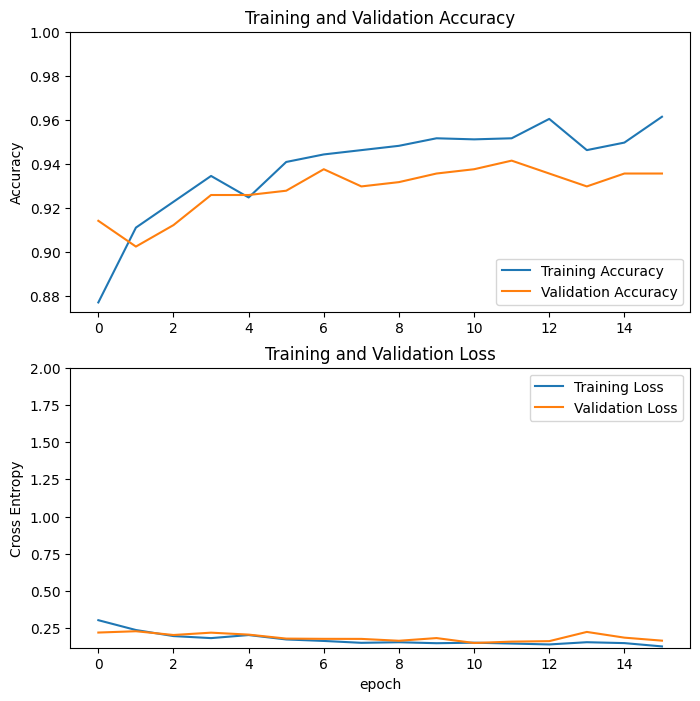

In [19]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [21]:
# Evaluate the model on the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary",
    shuffle = False
)

Found 231 images belonging to 2 classes.


In [22]:
loss, accuracy = model1.evaluate(test_generator, steps=test_generator.samples // 32)

7/7 [==============================] - 1s 131ms/step - loss: 0.1251 - Accuracy: 0.9598


In [23]:
# Predict on the test data
predictions = model1.predict(test_generator)

8/8 [==============================] - 3s 453ms/step


In [24]:
y_true = test_generator.classes

In [25]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)

# Calculate AUC
auc_score = auc(fpr, tpr)

# Find the threshold maximizing Youden's J statistic
max_j_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[max_j_idx]

print("AUC:", auc_score)
print("Optimal threshold:", optimal_thresh)

AUC: 0.9904754762261887
Optimal threshold: 0.61939484


In [29]:
y_pred = (predictions > optimal_thresh ).astype("int32")

In [30]:
# Generate classification report and confusion matrix
print("Classification report:")
print(classification_report(y_true, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       113
           1       0.96      0.97      0.96       118

    accuracy                           0.96       231
   macro avg       0.96      0.96      0.96       231
weighted avg       0.96      0.96      0.96       231



In [31]:
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

Confusion matrix:
[[108   5]
 [  4 114]]


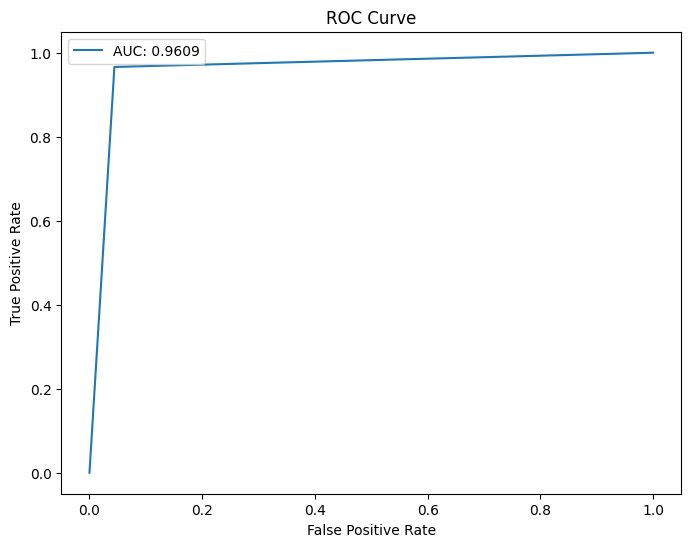

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the AUC
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC: {auc_score:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**Test Accuracy for VGG16 model is found to be 95.54%**

In [ ]:
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9554
